# Analizando Datos en Grupos con *pandas*

Es común, al analizar datos, tener variables categóricas o grupos definidos dentro de los datos. *pandas* permite trabajar facilmente con este tipo de datos usando la estrategia [*split-apply-combine*.](http://pandas.pydata.org/pandas-docs/stable/groupby.html)  
En este caso usaremos el dataset *PlantGrowth* de *R* de un experimento de campo, donde se mide el peso seco para tres grupos de plantas.

In [1]:
! head -5 PlantGrowth.tsv

weight group
4.17 ctrl
5.58 ctrl
5.18 ctrl
6.11 ctrl


In [2]:
import pandas as pd

In [3]:
datos = pd.read_table("PlantGrowth.tsv", delimiter=" ")

In [4]:
datos.groupby("group").head(2) # Notar que aplica head() a cada grupo

weight group
group                 
ctrl  0     4.17  ctrl
      1     5.58  ctrl
trt1  10    4.81  trt1
      11    4.17  trt1
trt2  20    6.31  trt2
      21    5.12  trt2

[6 rows x 2 columns]

In [5]:
datos.groupby("group").describe()

weight
group                 
ctrl  count  10.000000
      mean    5.032000
      std     0.583091
      min     4.170000
      25%     4.550000
      50%     5.155000
      75%     5.292500
      max     6.110000
trt1  count  10.000000
      mean    4.661000
      std     0.793676
      min     3.590000
      25%     4.207500
      50%     4.550000
      75%     4.870000
      max     6.030000
trt2  count  10.000000
      mean    5.526000
      std     0.442573
      min     4.920000
      25%     5.267500
      50%     5.435000
      75%     5.735000
      max     6.310000

[24 rows x 1 columns]

In [6]:
%matplotlib inline

Uno puede dividir en grupos para aplicar una función que realice un gráfico sobre cada uno de los grupos.

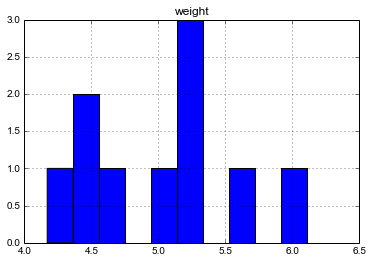

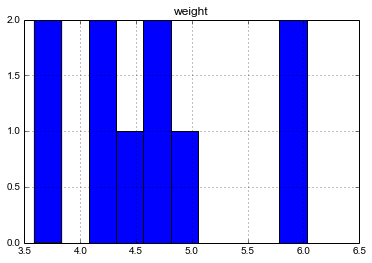

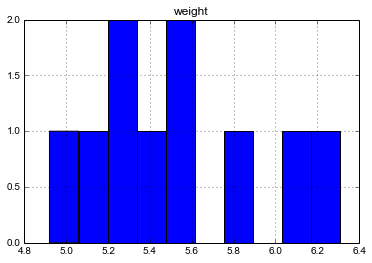

In [7]:
datos.groupby("group").hist("weight");

A veces las funciones para realizar gráficos poseen argumentos que nos permiten separar por grupos.

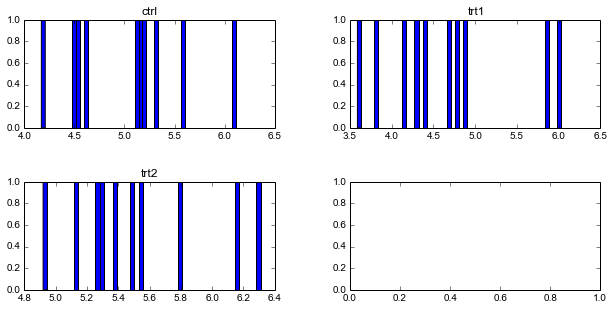

In [8]:
datos.hist("weight", by=datos["group"]);

*pandas* nos da la posibilidad de crear nuestras propias función para aplicarlas a un *DataFrame* usando [**apply()**](http://pandas.pydata.org/pandas-docs/stable/groupby.html#flexible-apply)

In [9]:
import numpy as np 

def media_error(subset, columna, index):
    array = subset[columna]
    return pd.Series( {"media":array.mean(), "error":array.std() / np.sqrt( len( array )  ) } )
    

In [10]:
resultado = datos.groupby("group").apply(media_error,columna="weight",index="group")

In [11]:
resultado

,error,media
group,,
ctrl,0.184390,5.032
trt1,0.250982,4.661
trt2,0.139954,5.526


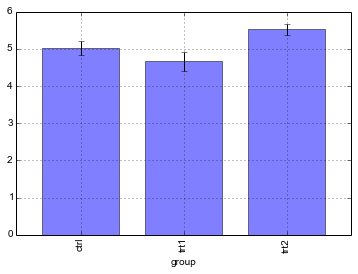

In [12]:
resultado.plot( y="media", yerr=resultado["error"], kind="bar", error_kw=dict(ecolor='k'), alpha=0.5);

Si necesitamos hacer algo estadísticamente más complicado, tenemos que usar [*scipy*](http://www.scipy.org/) & [*statsmodels*](http://statsmodels.sourceforge.net/). Por ejemplo, realizaremos un [*ANOVA*](http://statsmodels.sourceforge.net/devel/examples/generated/example_interactions.html) & [*Tukey-kramer HSD test*](http://en.wikipedia.org/wiki/Tukey's_range_test)

Para realizar un *ANOVA* primero debemos la testear normalidad de los datos usando **```stats.normaltest```**.

In [13]:
import scipy.stats as stats

In [14]:
datos["weight"].groupby( datos.group ).apply(stats.normaltest)

/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1293: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  int(n))


group
ctrl     (0.233495628907, 0.889809561981)
trt1     (0.967740620147, 0.616393136709)
trt2      (1.01317725871, 0.602547589896)
dtype: object

In [15]:
help(stats.normaltest)

Help on function normaltest in module scipy.stats.stats:

normaltest(a, axis=0)
    Tests whether a sample differs from a normal distribution.
    
    This function tests the null hypothesis that a sample comes
    from a normal distribution.  It is based on D'Agostino and
    Pearson's [1]_, [2]_ test that combines skew and kurtosis to
    produce an omnibus test of normality.
    
    
    Parameters
    ----------
    a : array_like
        The array containing the data to be tested.
    axis : int or None
        If None, the array is treated as a single data set, regardless of
        its shape.  Otherwise, each 1-d array along axis `axis` is tested.
    
    Returns
    -------
    k2 : float or array
        `s^2 + k^2`, where `s` is the z-score returned by `skewtest` and
        `k` is the z-score returned by `kurtosistest`.
    p-value : float or array
       A 2-sided chi squared probability for the hypothesis test.
    
    References
    ----------
    .. [1] D'Agostino, R

Una vez que testeamos la normalidad de los datos, podemos proseguir a realizar el *ANOVA*

In [16]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
modelo_lineal = ols("weight ~ group", datos).fit() # ordinary least squares 
modelo_lineal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     4.846
Date:                Tue, 21 Mar 2017   Prob (F-statistic):             0.0159
Time:                        23:43:37   Log-Likelihood:                -26.810
No. Observations:                  30   AIC:                             59.62
Df Residuals:                      27   BIC:                             63.82
Df Model:                           2                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         5.0320      0.197     25.527      0.000         4.628     5.436
group[T.trt1]    -0.3710      0.279     -1.331      0.194        -0.943     0.201
group[T.trt2]     0.4940      0.279      1.772      0.088        -0.078     1.066
==============================================================================
Omnibus:                        1.835   Durbin-Watson:                   2.704
Prob(Omnibus):                  0.400   Jarque-Bera (JB):                1.406
Skew:                           0.524   Prob(JB):                        0.495
Kurtosis:                       2.835   Cond. No.                         3.73
==============================================================================
"""

In [17]:
anova_lm(modelo_lineal)

,df,sum_sq,mean_sq,F,PR(>F)
group,2,3.76634,1.883170,4.846088,0.01591
Residual,27,10.49209,0.388596,NaN,NaN


In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [19]:
tukey = pairwise_tukeyhsd(datos.weight,datos.group)

In [20]:
print( tukey.summary() )

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -0.371  -1.0621 0.3201 False 
  0      2     0.494   -0.1971 1.1851 False 
  1      2     0.865    0.1739 1.5561  True 
--------------------------------------------
